# Titanic

## 0.Import Libraries

In [46]:
# 导入所需模块
print('模块版本查询:')
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import numpy as np
print("numpy version:{}".format(np.__version__))

import scipy as sp
print("scipy version%s" %(np.__version__))

import IPython
from IPython import display
print("IPython verison:{}".format(IPython.__version__))

import sklearn
print("sklearn version:{}".format(sklearn.__version__))

import os #has no attribute '__version__'

# misc libraries 杂质
import random
import time

#ignore warnings 无视警告，纯静输出
import warnings
warnings.filterwarnings('ignore')
print('-'*50,end='\n')

print('数据存储情况查看:')
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

模块版本查询:
Python version:3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
pandas version:0.23.4
numpy version:1.13.3
scipy version1.13.3
IPython verison:7.1.1
sklearn version:0.20.0
--------------------------------------------------
数据存储情况查看:
gender_result_2019414.csv
gender_result_2019415.csv
gender_submission.csv
test.csv
train.csv



In [47]:
# import data modelling libraries
# 整体分四类：模型算法、模型辅助、可视化、可视化参数设定

# 常用模型算法
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, \
discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# 模型辅助方法
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# 可视化
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

# 可视化参数设定
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# plt.rcParams['figure.figsize'] = (8.0, 4.0) # 设置figure_size尺寸
# plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
# plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style

## 1. 读取数据

In [48]:
filepath = '/share/GitHub/Kaggle/titanic/data' # 绝对路径
filename = 'train.csv'

def load_titanic_data(filepath=filepath,filename=filename):
    fullpath = os.path.join(filepath,filename)
    return pd.read_csv(fullpath)

In [49]:
df_raw = load_titanic_data() # 读取的train
df_raw.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S
666,667,0,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S
206,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S
865,866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
494,495,0,3,"Stanley, Mr. Edward Roland",male,21.0,0,0,A/4 45380,8.0500,NaN,S


各个维度意义说明:<BR>
- PassengerId: 单样本唯一标识      （无意义 去除）
- Survived: Survival	0 = No, 1 = Yes 目标变量
- Pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- Sex: sex
- Age: age in years
- SibSp: of siblings / spouses aboard the Titanic
- Parch: of parents / children aboard the Titanic
- Ticket: Ticket number   
- fare: Passenger fare
- Cabin: Cabin number   
- embarked: Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
----
- 2. PassengerID and Ticket 去除无序，随机的
- 3. Pclass 为顺序数据，有SES
- 4. Name 可以从名字的前缀如doctor, 或者family名的反应
- 5. Sex and Embarked 分类数据
- 6. Age 和 Fare 是连续数据
- 7. SibSp 和 Parch 用以生成家庭总人数和是否一个人的特征
- 8. Cabin缺失值较多，如何用待考虑

In [50]:
df_train = df_raw.copy(deep = True)
# df_train_raw = df_train.drop(['PassengerId','Name','Ticket','Cabin'],axis = 1) #drop会产生一个数据复本，不会影响df_train
# df_train_raw.head(5)


## 2.数据清洗 & 数据预处理

In [51]:
data_val = pd.read_csv('./data/test.csv')
data_cleaner = [df_train, data_val]
# data_cleaner # 构造data_cleaner的list方便后面遍历清洗

### 2.1 4C: Correcting, Completing, Creating, and Converting

- 1. Correcting: 对于连续型数据要注意离群值，但这里会在做完探索分析后再决定是否放入数据集；脱离常理，就应该去除
- 2. Completing: 对于一些算法是无法处理null和missing data，处理缺失数据：删除数据和有效数据方法填充，不建议删除数据记录，除非有大比例缺失
- 3. Creating: create feature
- 4. Converting: 时间格式和货币格式需要转化, 分类数据要onehot

In [52]:
print('Train columns with null values:\n', df_train.isnull().sum()) # train的缺失情况
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum()) # test的缺失情况
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


#### 小结:缺失数据情况
---
- train
Age            177
Cabin          687
Embarked         2
- test
Age             86
Fare             1
Cabin          327

### 2.2 Clean

In [53]:
# 填充缺失值
for dataset in data_cleaner:
    # complete age with median
    dataset.Age.fillna(dataset.Age.median(),inplace=True)
    
    # complete embarked with mode
    dataset.Embarked.fillna(dataset.Embarked.mode()[0],inplace=True)
    
    # complete missing fare with median
    dataset.Fare.fillna(dataset.Fare.median(), inplace = True)

drop_column = ['PassengerId','Cabin','Ticket']
df_train.drop(drop_column, axis = 1, inplace = True)

print(df_train.isnull().sum())
print('-'*50)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------------------------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


#### 小结
1. age_missing用中位数填充
2. Embarked用众数填充
3. Fare用中位数填充

### 2.2 CREATE

In [54]:
# 创建特征
for dataset in data_cleaner:
    # 离散数据
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1] = 0
    
    dataset['Title'] = dataset['Name'].str.split(',',expand=True)[1].\
                    str.split('.',expand = True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4) # 连续数据分组 分bins
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5) # 数据分组 分bins

# cleanup rare title names 对于稀少名号的处理，把10作为稀少的判断值
stat_min = 10
title_names = (df_train['Title'].value_counts() < stat_min)
title_names

df_train['Title'] = df_train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x) #???这里output是什么
print(df_train['Title'].value_counts())

# preview data again
data_cleaner[0].head(5)
df_train.info()
data_val.info()


 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object

#### 小结
- 新增'FamilySize', 公式：dataset ['SibSp'] + dataset['Parch'] + 1 ， +1是加自己
- 新增'IsAlone', 用familysize的做辅助判断
- 新增'Title', 为中间名
- 新增'farebin', 'agebin' 数据区间


In [55]:
df_train.columns.values

array(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'FareBin',
       'AgeBin'], dtype=object)

### 2.3 Convert

In [56]:
# labelencoder >> get_dummies()

label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
data_cleaner[0].head()


# 定义col名称来控制表格

# 定义 y aka target/outcome
Target = ['Survived']

# 定义 x 原始特征 和 计算后的特征
df_train_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
df_train_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
df_train_xy =  Target + df_train_x
print('Original X Y: ', df_train_xy, '\n')

# 定义 x 特征去除连续变量
df_train_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
df_train_xy_bin = Target + df_train_x_bin
print('Bin X Y: ', df_train_xy_bin, '\n')

# 定义 x dummy化
df_train_dummy = pd.get_dummies(df_train[df_train_x])
df_train_x_dummy = df_train_dummy.columns.tolist()
df_train_xy_dummy = Target + df_train_x_dummy
print('Dummy X Y: ', df_train_xy_dummy, '\n')

df_train_dummy.head()



Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_Misc'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0


#### 小结
1. 有两种数据处理的编程思路，一种是文档探索式，一步一步写，适合刚接触新的数据集，二种是pipeline的思路，将处理过程工程化
2. labelencoder需要结合get_dummies来替代 onehotencoder(onehotencoder是否能对df处理)

### 2.4 二次检查数据清洗

In [57]:
print('Train columns with null values: \n', df_train.isnull().sum())
print("-"*10)
print (df_train.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

df_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null catego

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Yousif, Mr. Wazli",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 划分数据集


In [58]:
# 用 model_selecton.train_test_split(),去划分
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(df_train[df_train_x_calc],df_train[Target],random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(df_train[df_train_x_bin], df_train[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(df_train_dummy[df_train_x_dummy], df_train[Target], random_state = 0)

print("Data1 Shape: {}".format(df_train.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))


Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


In [59]:
train1_x_bin.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,1,0
68,0,3,2,1,7,1,1
253,1,3,2,2,2,1,2
320,1,3,2,2,1,1,0
706,0,2,2,3,1,2,1


In [60]:
train1_x.head()

,Sex_Code,Pclass,Embarked_Code,Title_Code,SibSp,Parch,Age,Fare
105,1,3,2,2,0,0,28.0,7.8958
68,0,3,2,1,4,2,17.0,7.9250
253,1,3,2,2,1,0,30.0,16.1000
320,1,3,2,2,0,0,22.0,7.2500
706,0,2,2,3,0,0,45.0,13.5000


In [61]:
train1_x_dummy.head()

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
105,3,0,0,28.0,7.8958,1,1,0,1,0,0,1,0,0,1,0,0
68,3,4,2,17.0,7.9250,7,0,1,0,0,0,1,0,1,0,0,0
253,3,1,0,30.0,16.1000,2,0,0,1,0,0,1,0,0,1,0,0
320,3,0,0,22.0,7.2500,1,1,0,1,0,0,1,0,0,1,0,0
706,2,0,0,45.0,13.5000,1,1,1,0,0,0,1,0,0,0,1,0


#### 小结
1. 这里把数据集处理成三种：
    - 一是原始，只是分类数据和顺序数据处理了；
    - 二是处理了基于原始数据处理了pd.cut了连续型数据，分组；
    - 三是基于第二种onehot化
2. 划分数据集用model_selection.train_test_split,默认是75/25 split

## 3. 数据可视化

In [62]:
for x in df_train_x:
    if df_train[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(df_train[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
     Title  Survived
0   Master  0.575000
1     Miss  0.697802
2       Mr  0.156673
3      Mrs  0.792000
4     Misc  0.444444
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303

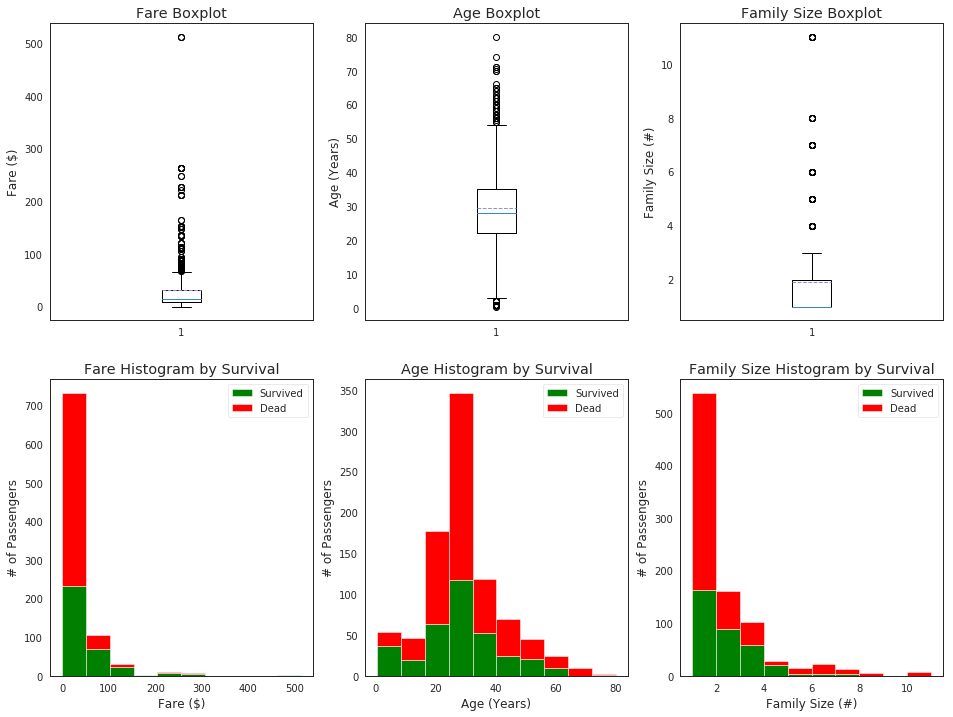

In [63]:
# --------------------------------------------------------------
  # 这里可以注意两种子图编程方式，
  # 一是plt.figure,在后面plt.subplot(231)来控制位置信息
  # 二是plt.subplots来定义画布和axis, 然后在每个画图函数中去用ax参数 = axis来确定子图位置
# --------------------------------------------------------------
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=df_train['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(df_train['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(df_train['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [df_train[df_train['Survived']==1]['Fare'], df_train[df_train['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [df_train[df_train['Survived']==1]['Age'], df_train[df_train['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [df_train[df_train['Survived']==1]['FamilySize'], df_train[df_train['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()


---
箱线图：QR是四分位距，Q3-Q1;内限(异常值截断点)为Q1-1.5QR,Q3+1.5QR;外限(极端值截断点)：Median+3QR
- 适用
    - 不要求数据服从正态分布；
- 判断异常条件
    - 数据小于Q1-QR1.5或者数据大于Q3+1.5QR为异常值；
---
HIST值得学习，stacked

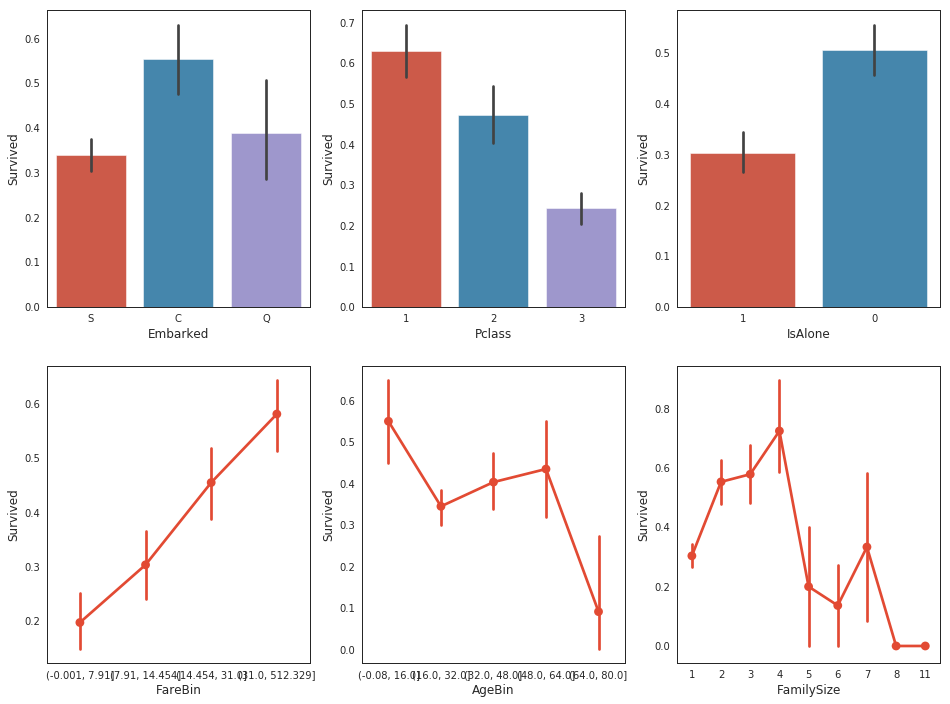

In [64]:
#we will use seaborn graphics for multi-variable comparison: https://seaborn.pydata.org/api.html

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=df_train, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=df_train, ax = saxis[0,1]) #order
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=df_train, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=df_train, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=df_train, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=df_train, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

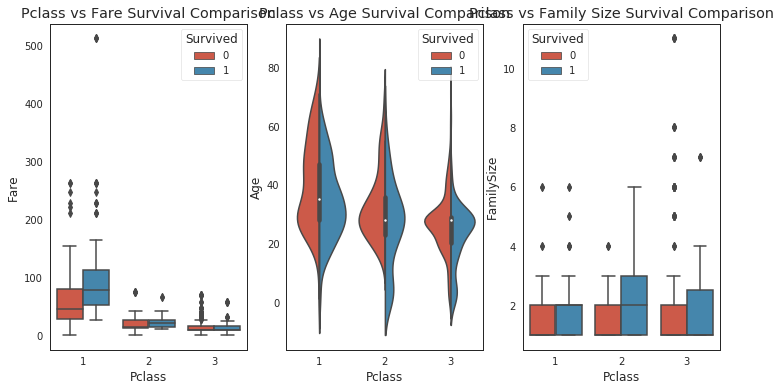

In [65]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,6))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = df_train, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = df_train, split = True, ax = axis2) # 连续值用violinplot可以看分布
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = df_train, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

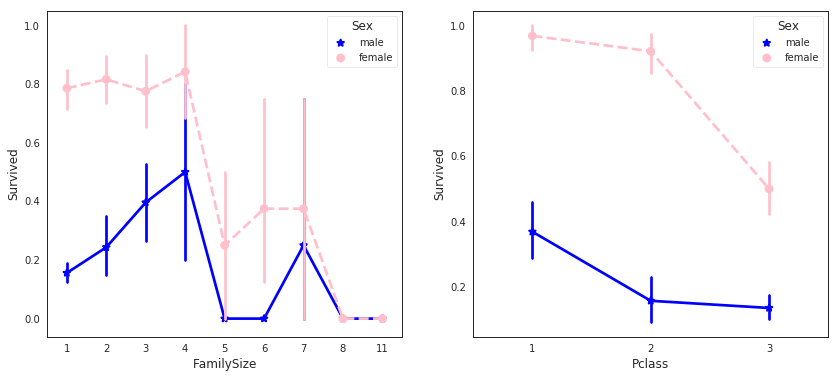

In [66]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,6))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=df_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

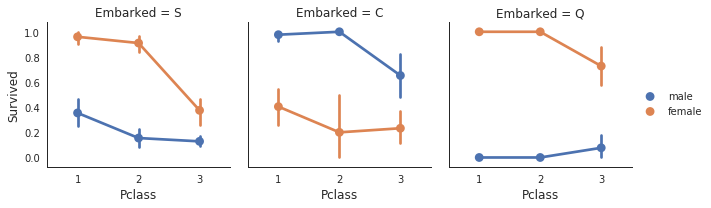

In [67]:
# ----------
# 用sns.FacetGrid来构造多子图结构
# ----------
#how does embark port factor with class, sex, and survival compare
#facetgrid: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
e = sns.FacetGrid(df_train, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

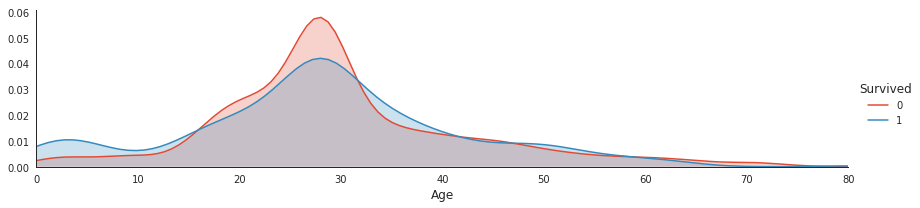

In [68]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(df_train, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , df_train['Age'].max()))
a.add_legend()

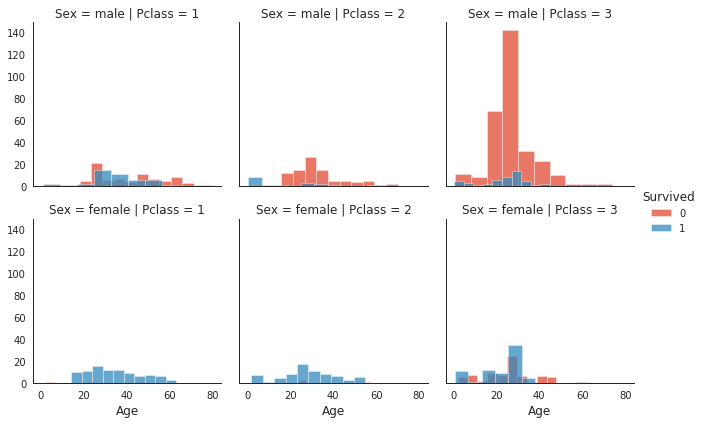

In [69]:
#histogram comparison of sex, class, and age by survival
h = sns.FacetGrid(df_train, row = 'Sex', col = 'Pclass', hue = 'Survived') # 学习！！！
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

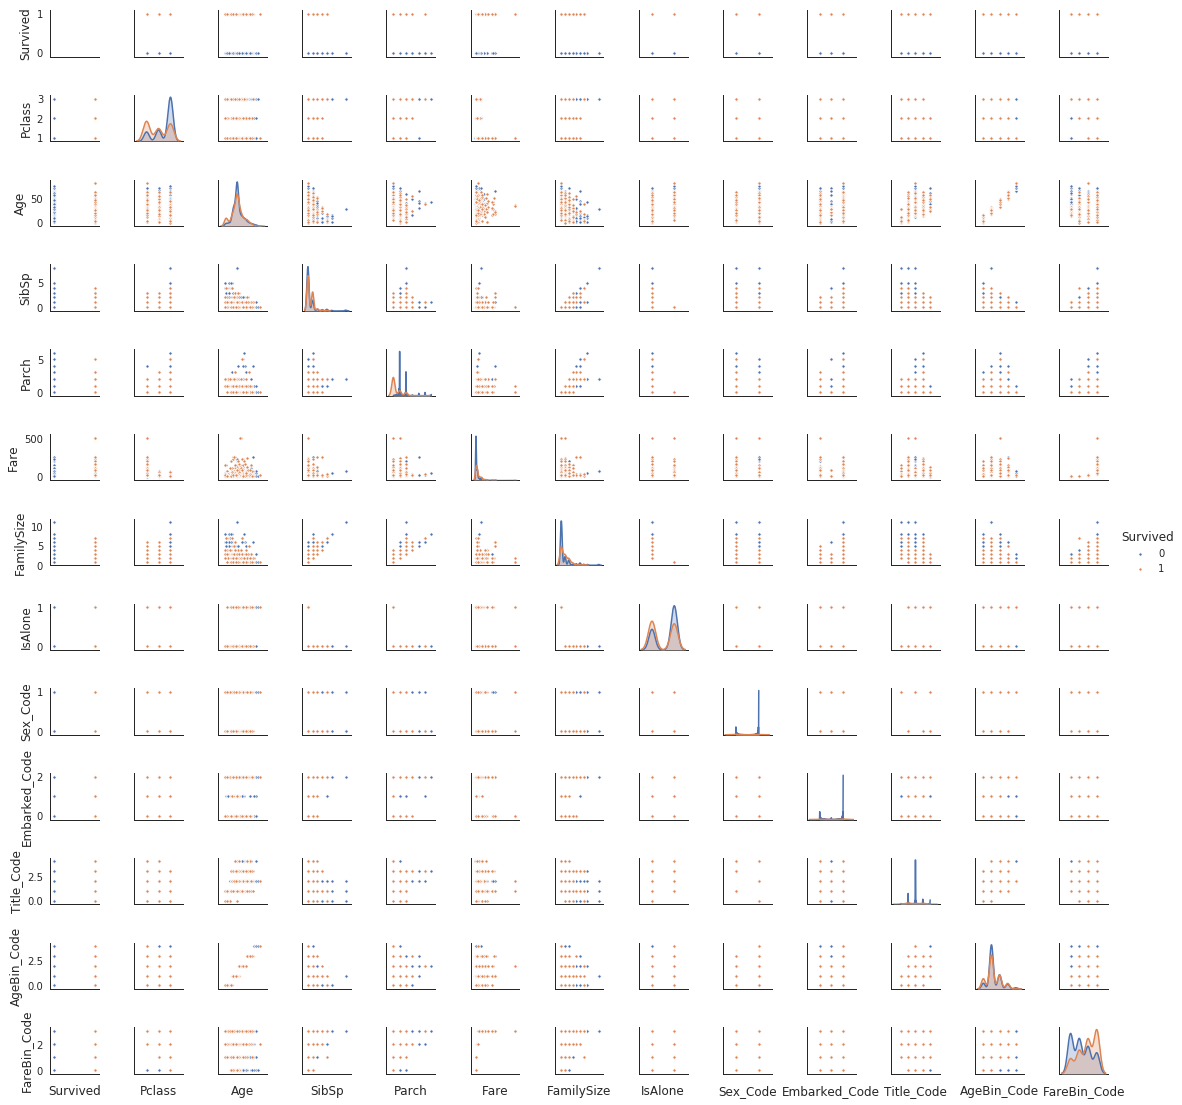

In [70]:
#pair plots of entire dataset
pp = sns.pairplot(df_train, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

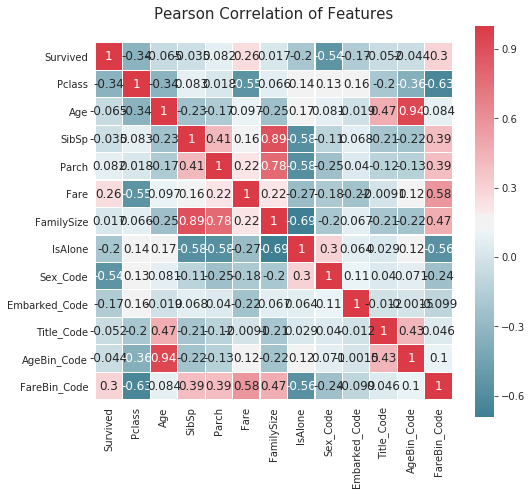

In [71]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(8, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_train)

## 4. 建模

In [72]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_train[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, df_train[df_train_x_bin], df_train[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(df_train[df_train_x_bin], df_train[Target])
    MLA_predict[MLA_name] = alg.predict(df_train[df_train_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict



,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.827239,0.0430788,0.030972
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.839139,0.826866,0.0439856,0.0402913
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.836517,0.826119,0.0470149,0.0464795
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.892135,0.822761,0.0635699,0.0135465
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891386,0.822015,0.0596653,0.014666
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.822015,0.0635304,0.0129693
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.867041,0.821642,0.0517353,0.0643149
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.820149,0.05769,0.00298672
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.849625,0.819776,0.0631347,0.0028892
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820599,0.810075,0.0476108,0.0643099


Text(0,0.5,'Algorithm')

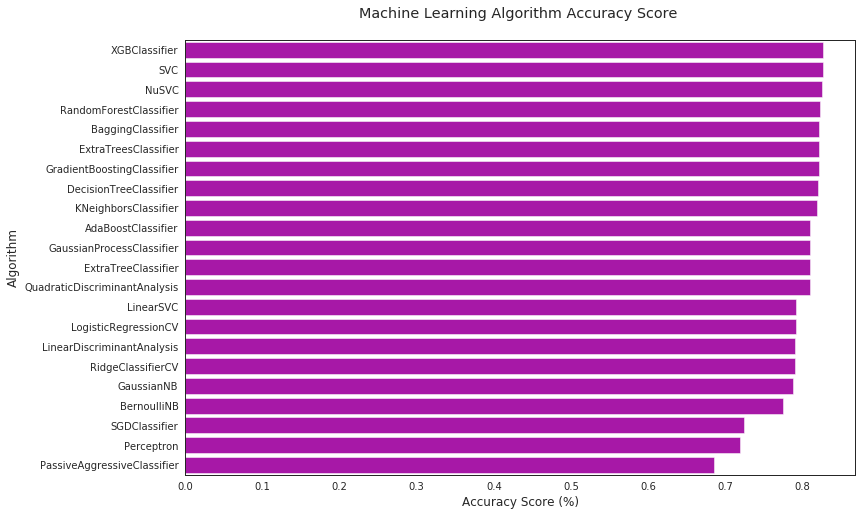

In [73]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [86]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, df_train_dummy[df_train_x_dummy],df_train[Target], cv  = cv_split)
vote_hard.fit(df_train_dummy[df_train_x_dummy], df_train[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, df_train_dummy[df_train_x_dummy], df_train[Target], cv  = cv_split)
vote_soft.fit(df_train_dummy[df_train_x_dummy], df_train[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)


Hard Voting Training w/bin score mean: 92.40
Hard Voting Test w/bin score mean: 83.54
Hard Voting Test w/bin score 3*std: +/- 5.45
----------
Soft Voting Training w/bin score mean: 91.72
Soft Voting Test w/bin score mean: 83.02
Soft Voting Test w/bin score 3*std: +/- 5.30
----------


In [96]:
stat_min = 10
title_names = (data_val['Title'].value_counts() < stat_min)
title_names

data_val['Title'] = data_val['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [97]:
# data_val dummy化
data_val_dummy = pd.get_dummies(data_val[df_train_x])
data_val_x_dummy = data_val_dummy.columns.tolist()
data_val_xy_dummy = Target + data_val_x_dummy
print('Dummy X Y: ', data_val_xy_dummy, '\n')

data_val_dummy.head()

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_Misc'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,0,0,34.5,7.8292,1,1,0,1,0,1,0,0,0,1,0,0
1,3,1,0,47.0,7.0000,2,0,1,0,0,0,1,0,0,0,1,0
2,2,0,0,62.0,9.6875,1,1,0,1,0,1,0,0,0,1,0,0
3,3,0,0,27.0,8.6625,1,1,0,1,0,0,1,0,0,1,0,0
4,3,1,1,22.0,12.2875,3,0,1,0,0,0,1,0,0,0,1,0


In [101]:
final_prediction = vote_hard.predict(data_val_dummy[data_val_x_dummy])

## 5.试验结果转换成submission格式

In [102]:
num_list = range(892,1310)
result_list = final_prediction.tolist()
df_submission = pd.DataFrame({'PassengerId':num_list,'Survived':result_list})
df_submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [103]:
df_submission.to_csv ("gender_result_2019521.csv" , encoding = "utf-8",index=None)